# Chasing Orbital Cyclicities in the Eastern Tropical Pacific

This notebook explores the results from the spectral, wavelet, and cross-wavelet analysis of a sea surface temperature reconstruction from Site ODP846 in the Eastern Equatorial Pacific. The worflow execution were done through [PaleoTS](http://linked.earth/paleoTS/), an automated system for the analysis of paleoclimate timeseries data. A description of the performed analyses is available [here](http://linked.earth/paleoTS/workflow.html).

First, let's import the necessary packages:
- the [wings package](https://pypi.org/project/wings/) (which allows to interface with the WINGS (PaleoTS) APIs without the GUI)
- Pandas, which will be used to query the results based on the specific outputs, parameters and combination thereof
- [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/master/) to parse the results of the analyses. 

In [25]:
import wings
from wings.execution import Execution
from wings.data import Data

import os.path
import json
import pandas as pd
import time
import datetime

import pyleoclim as pyleo

import getpass

The following cell contains login credentials for the runs on PaleoTS: 

In [27]:
SERVER = "https://datascience4all.org/wings-portal-new"
INTERNAL_SERVER = SERVER

USERID = "dkhider"
PASSWORD = getpass.getpass()
DOMAIN = "PaleoTS"

CACHEDIR = "data"

 ··········


Make a data folder if it doesn't already exist. Relevent outputs from PaleoTS will be downloaded to this folder. 

In [3]:
if os.path.exists('data')==True:
    pass
else:
    cwd = os.getcwd()+'/'
    path = os.path.join(cwd, 'data')
    os.mkdir(path)

In [28]:
api = wings.ApiClient(server=SERVER, username=USERID, password=PASSWORD)
api.set_domain(DOMAIN)

In [29]:
execution_api = Execution(api)
data_api = Data(api)

The functions below allow parsing for the parameters and output/intermediate files:

In [30]:
def get_execution_parameters(exec):
    variables = exec["variables"]
    params = {}
    for var in variables["input"]:
        if var["type"] == 2:
            vbinding = var["binding"]
            if vbinding["type"] == "literal":
                varname = var["id"].split("#")[1]
                #dtype = vbinding["datatype"].split("#")[1]
                value = vbinding["value"]
                params[varname] = value
    return params

def get_execution_files(exec, file_types=[], fetch_datasets_for_variables=[]):
    variables = exec["variables"]
    files = {}
    allvars = []

    for file_type in file_types:
        allvars += variables[file_type]
    for var in allvars:
        if var["type"] == 1:
            vbinding = var["binding"]
            if vbinding["type"] == "uri":
                varname = var["id"].split("#")[1]
                location = None
                dataid = vbinding["id"]
                dataname = dataid.split("#")[1]
                # Download datasets for variables if needed
                if varname in fetch_datasets_for_variables:
                    location = CACHEDIR + "/" + dataname
                    if not os.path.exists(location):
                        data_api.fetch_data(dataid, location)
                    files[varname] = location
    return files

## Data Exploration

Our first task was to extract the sea surface temperature data from the file and build a dashboard. Let's have a look at the dashboard directly:

## Spectral Analysis

Let's fecth the results from the spectral analysis workflow:

In [6]:
execs = execution_api.list_executions_by_page(pattern="SpectralAnalysis*")

Apply a start and end time for the analysis of interests:

In [7]:
start_string = "12/14/2022 10:38:00-08:00" #Date and Time of the start of the runs, -08:00 accounts for PST timezone
start = time.mktime(datetime.datetime.strptime(start_string, '%m/%d/%Y %H:%M:%S%z').timetuple()) #convert to datetime

end_string = "12/16/2022 06:00:00-08:00"
end = time.mktime(datetime.datetime.strptime(end_string, '%m/%d/%Y %H:%M:%S%z').timetuple()) #convert to datetime

Get a list of all the executions within that time frame:

In [8]:
full_execs = []
if execs["success"]:
    for ex in execs["rows"]:
        runid = ex["id"].split("#")[1]
        status = ex["runtimeInfo"]["status"]
        startTime = ex["runtimeInfo"]["startTime"]
        if status == "SUCCESS" and startTime >= start and startTime <= end:
            print(str(len(full_execs) + 1) + ". Run id: " + runid)
            exec = execution_api.get_run_details(runid)
            full_execs.append(exec)

1. Run id: SpectralAnalysis-d5a90767-273e-47e9-96e0-8634b6f5fe72
2. Run id: SpectralAnalysis-771fbb05-9f45-4a62-aac3-7249d9c081ab
3. Run id: SpectralAnalysis-6580eb25-fae9-4457-9c51-3a6fb658ac02
4. Run id: SpectralAnalysis-b99a072d-b651-48d3-b162-d8eccb865fab
5. Run id: SpectralAnalysis-ac35cf8b-f803-47a3-8e8b-5be2a968f1d4
6. Run id: SpectralAnalysis-db8c185b-6ca6-449e-9393-359b81259b07
7. Run id: SpectralAnalysis-7b2016c2-41bb-49cd-919a-6d75457c627a
8. Run id: SpectralAnalysis-c91c7eae-01c6-4c3e-a4c5-67a516b326fc
9. Run id: SpectralAnalysis-fc61c8c9-6a94-4e99-9540-79967b454477
10. Run id: SpectralAnalysis-6ad768cf-1e6f-492e-bef8-5dbfda8fb244
11. Run id: SpectralAnalysis-8dfed98b-ccee-4a09-a6b3-0c0b7d0a887b
12. Run id: SpectralAnalysis-44615af2-232c-4d96-ad69-b5c582cfe50b
13. Run id: SpectralAnalysis-e56d82c4-4adc-4b2f-941a-8401d6a8c49b
14. Run id: SpectralAnalysis-6d2bf500-a84d-48e6-9490-2d51077d9d97
15. Run id: SpectralAnalysis-6dea9762-18c1-4921-8321-7e63a8cde049
16. Run id: Spectra

In [11]:
df = None
all_rows = []
for exec in full_execs:
    steps = exec["execution"]["plan"]["steps"]
    cvalues = {}
    for step in steps:
        cname = step["codeBinding"]["codeDirectory"].split("/")[-1]
        cvalues[cname] = True

    params = get_execution_parameters(exec)
    input_files = get_execution_files(exec, ["input"], ["InputTS"])
    output_files = get_execution_files(exec, ["intermediate", "output"], ["OutputTS7", "Out])

    row = dict(params)
    row.update(input_files)
    row.update(output_files)
    row.update(cvalues)

    if df is None:
        df = pd.DataFrame()
    
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

df

,adaptive,max_clusters,start,NW,step,windowLength,deriv,polyorder,qs,remove,...,metric,min_samples,eps,nbr_clusters,n_neighbors,DBSCAN,DetrendLinear,NoDetrending,n,DetrendEMD
0,false,10,-1.0,-1.0,-1.0,-1,0,2,0.95,true,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,10,-1.0,NaN,-1.0,-1,0,2,0.95,true,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,10,-1.0,NaN,-1.0,-1,0,2,0.95,true,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,10,-1.0,NaN,-1.0,-1,0,2,0.95,true,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,10,-1.0,NaN,-1.0,-1,0,2,0.95,true,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,NaN,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,0.95,false,...,euclidean,-1,-1.0,-1,-1,True,NaN,True,NaN,NaN
379,NaN,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,0.95,false,...,euclidean,-1,-1.0,-1,-1,True,NaN,NaN,1,True
380,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,0.95,false,...,euclidean,-1,-1.0,-1,-1,True,True,NaN,NaN,NaN
381,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,0.95,false,...,euclidean,-1,-1.0,-1,-1,True,NaN,True,NaN,NaN


In [16]:
df['OutputTS7'][0]

'data/OutputTS7-1eldzvuo0mjsfaau6khda3mh9.json'

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='temp muller [deg C]'>)

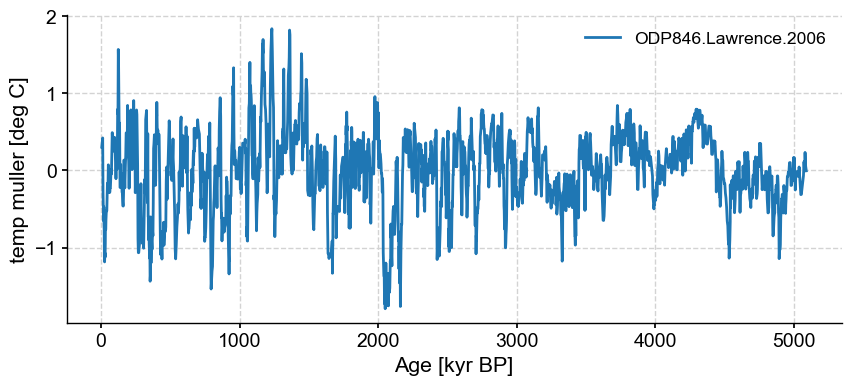

In [17]:
ts = pyleo.utils.jsonutils.json_to_PyleoObj(df['OutputTS7'][0],'Series')
ts.plot()